In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import Input

def conv_block(input_tensor, num_filters):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = tf.keras.layers.Activation("relu")(x)

    # second layer
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    return x

def encoder_block(input_tensor, num_filters):
    """Function to add 2 convolutional layers with the parameters passed to it and then perform max pooling"""
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    """Function to perform upconvolution and concatenate the upconvolved tensor with the tensor from the contracting path"""
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(input_tensor)
    x = concatenate([x, concat_tensor], axis=-1)
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    """Function to build a U-Net using the functions defined above"""

    inputs = Input(input_shape)

    # Contracting Path (Encoder)
    c1, p1 = encoder_block(inputs, 16)
    c2, p2 = encoder_block(p1, 32)
    c3, p3 = encoder_block(p2, 64)
    c4, p4 = encoder_block(p3, 128)
    
    # Bottleneck
    b = conv_block(p4, 256)

    # Expansive Path (Decoder)
    d1 = decoder_block(b, c4, 128)
    d2 = decoder_block(d1, c3, 64)
    d3 = decoder_block(d2, c2, 32)
    d4 = decoder_block(d3, c1, 16)

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Set the input shape (e.g., 128x128x1 for grayscale images)
input_shape = (128, 128, 1)
model = build_unet(input_shape)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()






Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         160       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['activation[0][0]']          
                                                                                          

In [2]:
# Gold standard with report and center cropping

import os
import torch
from monai.networks.nets import UNet
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ToTensord, RandRotate90d, CenterSpatialCropd
)
from monai.data import DataLoader, Dataset
from monai.losses import DiceLoss
from torch.optim import Adam
import matplotlib.pyplot as plt
from monai.handlers import StatsHandler, TensorBoardImageHandler
from monai.utils import set_determinism
from torch.utils.tensorboard import SummaryWriter

# Set determinism for reproducibility
set_determinism(seed=0)


# MONAI's transforms for dictionary format use 'd' at the end
# Assuming EnsureChannelFirstd is a valid replacement for AddChannel

print("Setting up directories and initial configurations...")


def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):  # Identifies the image files
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")  # Creates the label filename
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts

# Set the paths for the training and validation data directories
train_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Train"
val_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Validation"

# Desired sizes for cropping (not used in create_dataset but may be used elsewhere)
desired_height, desired_width, desired_depth = 128, 128, 128 

print("Creating datasets...")
train_files = create_dataset(train_data_dir)  # Only get files from the "Train" folder
val_files = create_dataset(val_data_dir)  

# Data Transformations
print("Defining transformations...")
roi_size = (desired_depth, desired_height, desired_width)  # Define the size of the cropped region
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    CenterSpatialCropd(keys=['image', 'label'], roi_size=roi_size), # Use random cropping
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ToTensord(keys=['image', 'label']),
]) 

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    CenterSpatialCropd(keys=['image', 'label'], roi_size=roi_size),  # Use random cropping for validation as well
    ToTensord(keys=['image', 'label']),
]) 

train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True) #collate_fn=pad_list_data_collate
val_loader = DataLoader(val_ds, batch_size=1) # collate_fn=pad_list_data_collate

# UNet Model Initialization

print("Initializing 3D U-Net model...")

model = UNet(
    spatial_dims=3,  # This specifies that the network should be 3D
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2)
)

# Loss Function and Optimizer
loss_function = DiceLoss(to_onehot_y=True, softmax=True) #to_onehot_y=True,
optimizer = Adam(model.parameters(), 1e-3) # This is the learning rate 
model_save_path = "z:/W-People/Nate/Deep_Learning_Data/Deep Learning Model/Nate_Unet.pth"
optimizer_save_path = "z:/W-People/Nate/Deep_Learning_Data/Deep Learning Model/Nate_Unet_optimzer.pth"
# Load the state dict into the model

# if os.path.exists(model_save_path) and os.path.exists(optimizer_save_path):
#     model.load_state_dict(torch.load(model_save_path))
#     optimizer.load_state_dict(torch.load(optimizer_save_path))
    # print("Loaded saved model and optimizer.")
# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training and Validation Functions
def train_epoch(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0
    for batch_data in loader:
        inputs, targets = batch_data['image'], batch_data['label']
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)


def validate_epoch(model, loader, loss_function, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch_data in loader:
            inputs, targets = batch_data['image'], batch_data['label']
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

# Main Training Loop
train_losses = []
val_losses = []



print("Starting training process...")
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, loss_function, device)
    val_loss = validate_epoch(model, val_loader, loss_function, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
   


    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

torch.save(model.state_dict(), model_save_path)
torch.save(optimizer.state_dict(), optimizer_save_path)
print(f"Model and optimizer states saved to {model_save_path} and {optimizer_save_path} respectively.")


# Plotting loss curves
print("Plotting loss curves...")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend()
plt.show()


Setting up directories and initial configurations...
Creating datasets...
Defining transformations...
Initializing 3D U-Net model...
Starting training process...
Epoch 1/20, Train Loss: 0.6879444122314453, Validation Loss: 0.6544718742370605
Epoch 2/20, Train Loss: 0.6603469848632812, Validation Loss: 0.6300693154335022
Epoch 3/20, Train Loss: 0.6344551146030426, Validation Loss: 0.6155858397483825
Epoch 4/20, Train Loss: 0.6115964651107788, Validation Loss: 0.6051682710647583
Epoch 5/20, Train Loss: 0.5904766023159027, Validation Loss: 0.59211106300354
Epoch 6/20, Train Loss: 0.5718984007835388, Validation Loss: 0.5822209596633912
Epoch 7/20, Train Loss: 0.5539020597934723, Validation Loss: 0.5717812061309815
Epoch 8/20, Train Loss: 0.5376825928688049, Validation Loss: 0.5601087093353272
Epoch 9/20, Train Loss: 0.5175888538360596, Validation Loss: 0.5356040894985199
Epoch 10/20, Train Loss: 0.4994014948606491, Validation Loss: 0.5322492480278015
Epoch 11/20, Train Loss: 0.484164476394

In [1]:
# Gold standard with report and center cropping

import os
import torch
from monai.networks.nets import UNet
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ToTensord, RandRotate90d, CenterSpatialCropd
)
from monai.data import DataLoader, Dataset
from monai.losses import DiceLoss
from torch.optim import Adam
import matplotlib.pyplot as plt
from monai.handlers import StatsHandler, TensorBoardImageHandler
from monai.utils import set_determinism
from torch.utils.tensorboard import SummaryWriter

# Set determinism for reproducibility
set_determinism(seed=0)


# MONAI's transforms for dictionary format use 'd' at the end
# Assuming EnsureChannelFirstd is a valid replacement for AddChannel

print("Setting up directories and initial configurations...")


def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):  # Identifies the image files
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")  # Creates the label filename
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts

# Set the paths for the training and validation data directories
train_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Train"
val_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Validation"

# Desired sizes for cropping (not used in create_dataset but may be used elsewhere)
desired_height, desired_width, desired_depth = 128, 128, 128 

print("Creating datasets...")
train_files = create_dataset(train_data_dir)  # Only get files from the "Train" folder
val_files = create_dataset(val_data_dir)  

# Data Transformations
print("Defining transformations...")
roi_size = (desired_depth, desired_height, desired_width)  # Define the size of the cropped region
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    CenterSpatialCropd(keys=['image', 'label'], roi_size=roi_size),  # Use random cropping
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ToTensord(keys=['image', 'label']),
]) 

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    CenterSpatialCropd(keys=['image', 'label'], roi_size=roi_size),  # Use random cropping for validation as well
    ToTensord(keys=['image', 'label']),
]) 

train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True) #collate_fn=pad_list_data_collate
val_loader = DataLoader(val_ds, batch_size=1) # collate_fn=pad_list_data_collate

# UNet Model Initialization

print("Initializing 3D U-Net model...")

model = UNet(
    spatial_dims=3,  # This specifies that the network should be 3D
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2)
)

# Loss Function and Optimizer
loss_function = DiceLoss(to_onehot_y=True, softmax=True) #to_onehot_y=True,
optimizer = Adam(model.parameters(), 1e-3) # This is the learning rate 

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training and Validation Functions
def train_epoch(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0
    for batch_data in loader:
        inputs, targets = batch_data['image'], batch_data['label']
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

# writer = SummaryWriter()


def validate_epoch(model, loader, loss_function, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch_data in loader:
            inputs, targets = batch_data['image'], batch_data['label']
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

# Main Training Loop
train_losses = []
val_losses = []

# stats_handler = StatsHandler(output_transform=lambda x: None)
# tb_image_handler = TensorBoardImageHandler(
#     log_dir='./runs/', batch_transform=lambda x: (x['image'], x['label']), output_transform=lambda x: x['pred']
# )

print("Starting training process...")
num_epochs = 30
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, loss_function, device)
    val_loss = validate_epoch(model, val_loader, loss_function, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
   
    # writer.add_scalar("Loss/Train", train_loss, epoch)
    # writer.add_scalar("Loss/Validation", val_loss, epoch)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")


# writer.close()

# ADDING POIINT TO SAVE
# print("Visualizing transformed images...")
# plot_transformed_images(train_loader, num_images=1)

# Plotting loss curves
print("Plotting loss curves...")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend()
plt.show()


Setting up directories and initial configurations...
Creating datasets...
Defining transformations...
Initializing 3D U-Net model...
Starting training process...


Setting up directories and initial configurations...
Creating datasets...
Defining transformations...
Initializing 3D U-Net model...
Starting training process...
Epoch 1/5, Train Loss: 0.700760543346405, Validation Loss: 0.6691734790802002
Epoch 2/5, Train Loss: 0.6863122582435608, Validation Loss: 0.6537192463874817
Epoch 3/5, Train Loss: 0.671716034412384, Validation Loss: 0.6399907469749451
Epoch 4/5, Train Loss: 0.6571351289749146, Validation Loss: 0.6281655430793762
Epoch 5/5, Train Loss: 0.6431462168693542, Validation Loss: 0.616101086139679
Plotting loss curves...


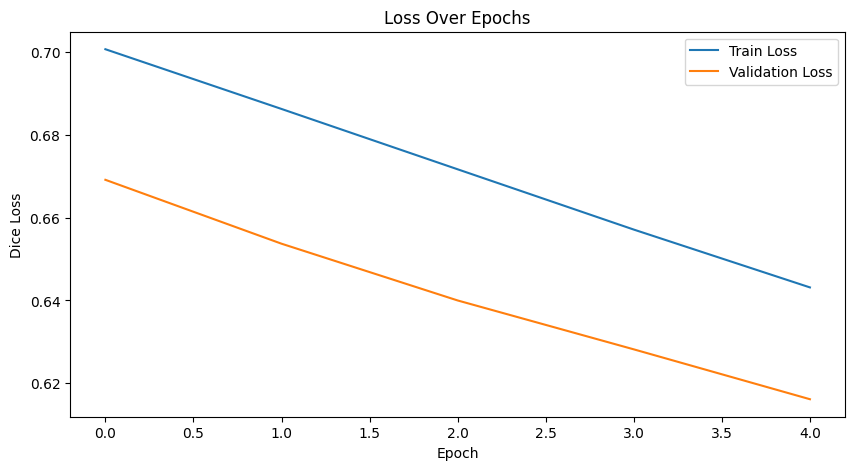

In [16]:
# Gold standard with report and center cropping

import os
import torch
from monai.networks.nets import UNet
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ToTensord, RandRotate90d, CenterSpatialCropd
)
from monai.data import DataLoader, Dataset
from monai.losses import DiceLoss
from torch.optim import Adam
import matplotlib.pyplot as plt



# MONAI's transforms for dictionary format use 'd' at the end
# Assuming EnsureChannelFirstd is a valid replacement for AddChannel

print("Setting up directories and initial configurations...")


def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):  # Identifies the image files
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")  # Creates the label filename
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts

# Set the paths for the training and validation data directories
train_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Train"
val_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Validation"

# Desired sizes for cropping (not used in create_dataset but may be used elsewhere)
desired_height, desired_width, desired_depth = 128, 128, 128 

print("Creating datasets...")
train_files = create_dataset(train_data_dir)  # Only get files from the "Train" folder
val_files = create_dataset(val_data_dir)  

# Data Transformations
print("Defining transformations...")
roi_size = (desired_depth, desired_height, desired_width)  # Define the size of the cropped region
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    CenterSpatialCropd(keys=['image', 'label'], roi_size=roi_size),  # Use random cropping
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ToTensord(keys=['image', 'label']),
]) 

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    CenterSpatialCropd(keys=['image', 'label'], roi_size=roi_size),  # Use random cropping for validation as well
    ToTensord(keys=['image', 'label']),
]) 

train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True) #collate_fn=pad_list_data_collate
val_loader = DataLoader(val_ds, batch_size=1) # collate_fn=pad_list_data_collate

# UNet Model Initialization

print("Initializing 3D U-Net model...")

model = UNet(
    spatial_dims=3,  # This specifies that the network should be 3D
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2)
)

# Loss Function and Optimizer
loss_function = DiceLoss(to_onehot_y=True, softmax=True) #to_onehot_y=True,
optimizer = Adam(model.parameters(), 1e-3) # This is the learning rate 

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training and Validation Functions
def train_epoch(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0
    for batch_data in loader:
        inputs, targets = batch_data['image'], batch_data['label']
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def validate_epoch(model, loader, loss_function, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch_data in loader:
            inputs, targets = batch_data['image'], batch_data['label']
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

# Main Training Loop
train_losses = []
val_losses = []

print("Starting training process...")
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, loss_function, device)
    val_loss = validate_epoch(model, val_loader, loss_function, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")



# ADDING POIINT TO SAVE
# print("Visualizing transformed images...")
# plot_transformed_images(train_loader, num_images=1)

# Plotting loss curves
print("Plotting loss curves...")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend()
plt.show()


Setting up directories and initial configurations...
Creating datasets...
Defining transformations...
Initializing 3D U-Net model...
Starting training process...
Epoch 1/50, Train Loss: 0.8237007260322571, Validation Loss: 0.8194394111633301
Epoch 2/50, Train Loss: 0.8190696239471436, Validation Loss: 0.8032989501953125
Epoch 3/50, Train Loss: 0.791276216506958, Validation Loss: 0.8075499534606934
Epoch 4/50, Train Loss: 0.8049917221069336, Validation Loss: 0.7941129207611084
Epoch 5/50, Train Loss: 0.8033766150474548, Validation Loss: 0.7763416171073914
Epoch 6/50, Train Loss: 0.7918484807014465, Validation Loss: 0.7959718704223633
Epoch 7/50, Train Loss: 0.7925307750701904, Validation Loss: 0.7923285961151123
Epoch 8/50, Train Loss: 0.776465654373169, Validation Loss: 0.7838568687438965
Epoch 9/50, Train Loss: 0.7767548561096191, Validation Loss: 0.7790942192077637
Epoch 10/50, Train Loss: 0.7736752033233643, Validation Loss: 0.7749133110046387
Epoch 11/50, Train Loss: 0.772881031036

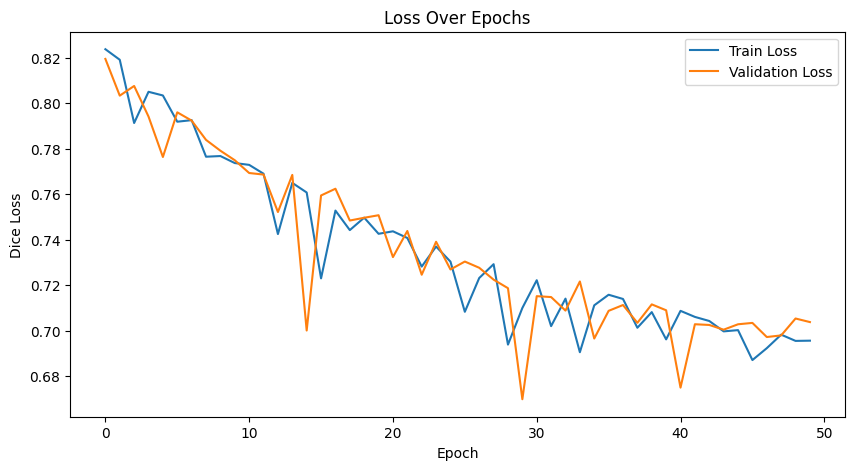

In [2]:
# Gold standard random cropping

import os
import torch
from monai.networks.nets import UNet
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, ToTensord, RandRotate90d
)
from monai.data import DataLoader, Dataset
from monai.losses import DiceLoss
from torch.optim import Adam
import matplotlib.pyplot as plt
from monai.data import pad_list_data_collate
from monai.transforms import Resized, SpatialPad
from monai.transforms import RandSpatialCropd 

# MONAI's transforms for dictionary format use 'd' at the end
# Assuming EnsureChannelFirstd is a valid replacement for AddChannel

print("Setting up directories and initial configurations...")


def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):  # Identifies the image files
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")  # Creates the label filename
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts

# Set the paths for the training and validation data directories
train_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Train"
val_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Validation"

# Desired sizes for cropping (not used in create_dataset but may be used elsewhere)
desired_height, desired_width, desired_depth = 128, 128, 128 

print("Creating datasets...")
train_files = create_dataset(train_data_dir)  # Only get files from the "Train" folder
val_files = create_dataset(val_data_dir)  

# Data Transformations
print("Defining transformations...")
roi_size = (desired_depth, desired_height, desired_width)  # Define the size of the cropped region
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),  # Use random cropping
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ToTensord(keys=['image', 'label']),
]) # ScaleIntensityd(keys=['image', 'label'])

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),  # Use random cropping for validation as well
    ToTensord(keys=['image', 'label']),
]) # ScaleIntensityd(keys=['image', 'label'])

train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True) #collate_fn=pad_list_data_collate
val_loader = DataLoader(val_ds, batch_size=1) # collate_fn=pad_list_data_collate

# UNet Model Initialization

print("Initializing 3D U-Net model...")

model = UNet(
    spatial_dims=3,  # This specifies that the network should be 3D
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2)
)

# Loss Function and Optimizer
loss_function = DiceLoss(to_onehot_y=True, softmax=True) #to_onehot_y=True,
optimizer = Adam(model.parameters(), 1e-3) # This is the learning rate 

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training and Validation Functions
def train_epoch(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0
    for batch_data in loader:
        inputs, targets = batch_data['image'], batch_data['label']
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def validate_epoch(model, loader, loss_function, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch_data in loader:
            inputs, targets = batch_data['image'], batch_data['label']
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

# Main Training Loop
train_losses = []
val_losses = []

print("Starting training process...")
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, loss_function, device)
    val_loss = validate_epoch(model, val_loader, loss_function, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")



# ADDING POIINT TO SAVE
# print("Visualizing transformed images...")
# plot_transformed_images(train_loader, num_images=1)

# Plotting loss curves
print("Plotting loss curves...")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend()
plt.show()


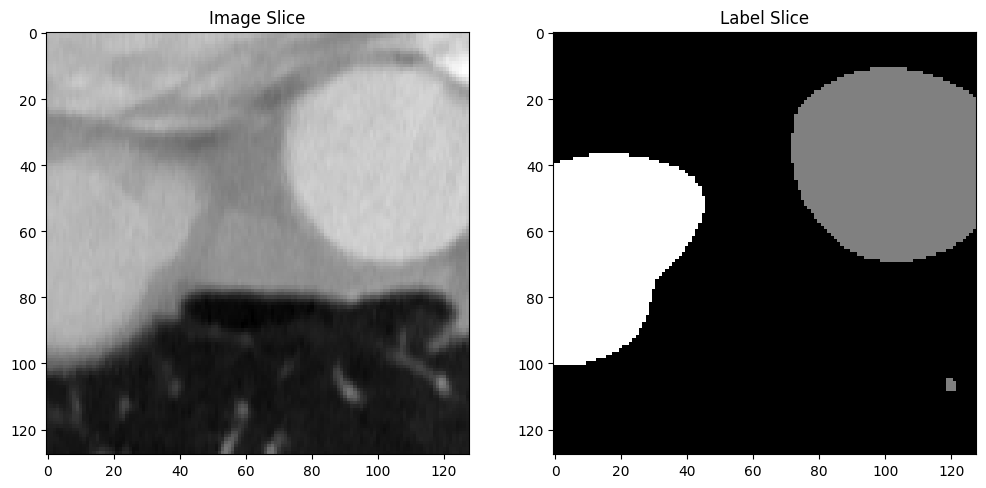

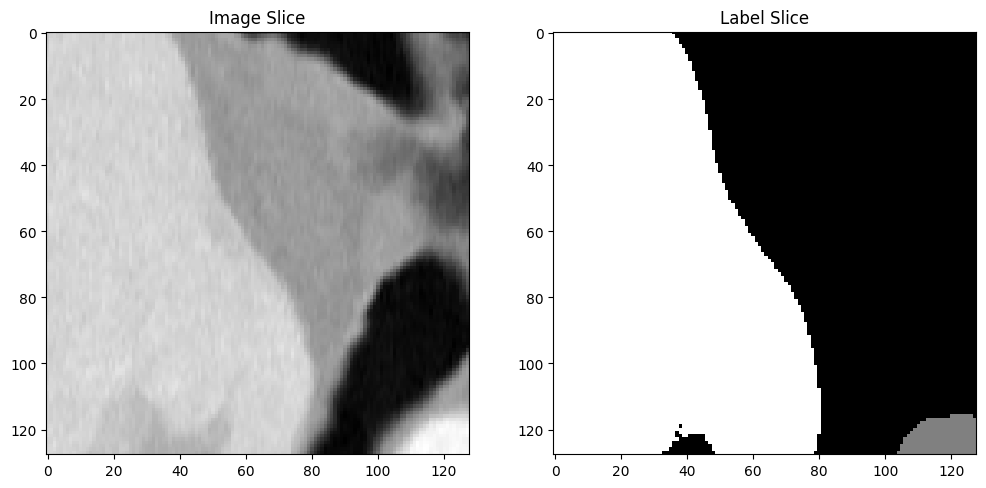

In [18]:
import numpy as np
def show_images(batch, slice_index=32, num_images=3):
    images, labels = batch['image'], batch['label']
    for i in range(min(num_images, len(images))):
        plt.figure(figsize=(12, 6))

        # Selecting a slice to display (e.g., the middle slice along the z-axis)
        image_slice = np.squeeze(images[i][0, slice_index, :, :])
        label_slice = np.squeeze(labels[i][0, slice_index, :, :])

        plt.subplot(1, 2, 1)
        plt.imshow(image_slice, cmap='gray')
        plt.title('Image Slice')

        plt.subplot(1, 2, 2)
        plt.imshow(label_slice, cmap='gray')
        plt.title('Label Slice')
        
        plt.show()

# Fetch a batch of data and show images
batch_data = next(iter(train_loader))
show_images(batch_data)


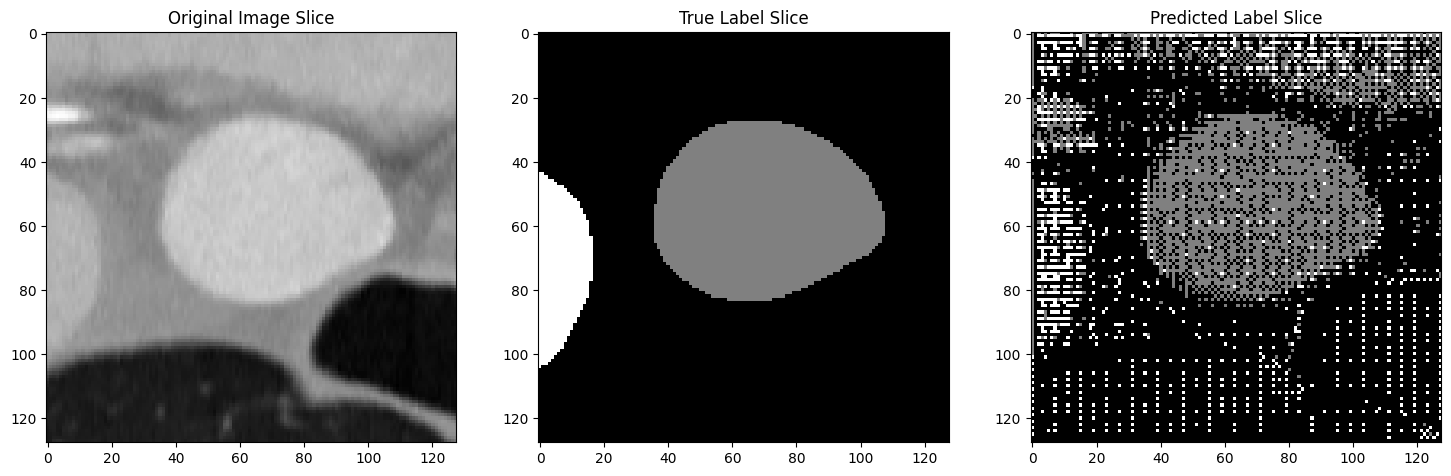

In [3]:
def visualize_predictions(loader, model, device, num_images=3, slice_index=32):
    model.eval()
    with torch.no_grad():
        batch = next(iter(loader))
        inputs, targets = batch['image'], batch['label']
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        # Convert model output to binary predictions
        predicted_labels = outputs.argmax(dim=1, keepdim=True)

        for i in range(min(num_images, len(inputs))):
            plt.figure(figsize=(18, 6))

            # Selecting a slice to display
            input_slice = np.squeeze(inputs[i].cpu()[0, slice_index, :, :])
            target_slice = np.squeeze(targets[i].cpu()[0, slice_index, :, :])
            predicted_slice = np.squeeze(predicted_labels[i].cpu()[0, slice_index, :, :])

            plt.subplot(1, 3, 1)
            plt.imshow(input_slice, cmap='gray')
            plt.title('Original Image Slice')

            plt.subplot(1, 3, 2)
            plt.imshow(target_slice, cmap='gray')
            plt.title('True Label Slice')

            plt.subplot(1, 3, 3)
            plt.imshow(predicted_slice, cmap='gray')
            plt.title('Predicted Label Slice')

            plt.show()

visualize_predictions(val_loader, model, device)


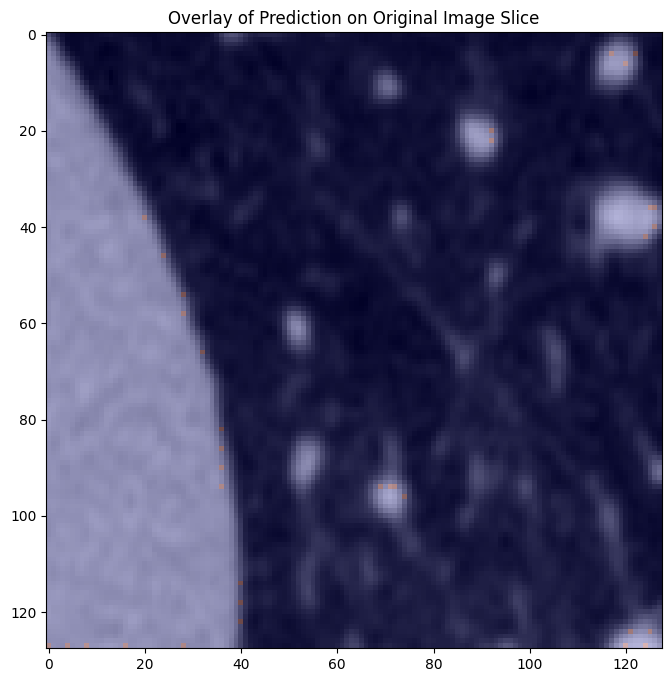

In [8]:
def overlay_predictions(batch, predictions, alpha=0.3, num_images=3, slice_index=32):
    images, labels = batch['image'], batch['label']
    for i in range(min(num_images, len(images))):
        plt.figure(figsize=(8, 8))

        # Selecting a slice to display
        image_slice = np.squeeze(images[i][0, slice_index, :, :])
        prediction_slice = np.squeeze(predictions[i][0, slice_index, :, :])

        plt.imshow(image_slice, cmap='gray')
        plt.imshow(prediction_slice, cmap='jet', alpha=alpha)
        plt.title('Overlay of Prediction on Original Image Slice')
        plt.show()

# Create overlay visualizations
batch_data = next(iter(val_loader))
model.eval()
with torch.no_grad():
    inputs = batch_data['image'].to(device)
    outputs = model(inputs)
    predicted_labels = outputs.argmax(dim=1, keepdim=True).cpu()
    overlay_predictions(batch_data, predicted_labels)


In [2]:
from mayavi import mlab
import numpy as np

def visualize_predictions_3d(loader, model, device, num_volumes=1):
    model.eval()
    with torch.no_grad():
        batch = next(iter(loader))
        inputs, targets = batch['image'], batch['label']
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        # Convert model output to binary predictions
        predicted_labels = outputs.argmax(dim=1, keepdim=True)

        for i in range(min(num_volumes, len(inputs))):
            # Reconstruct 3D volumes
            input_volume = inputs[i].cpu().squeeze().numpy()
            target_volume = targets[i].cpu().squeeze().numpy()
            predicted_volume = predicted_labels[i].cpu().squeeze().numpy()

            # Set up a figure
            fig = mlab.figure(size=(800, 800), bgcolor = (0,0,0))

            # Visualize original image volume
            #mlab.contour3d(input_volume, contours=[input_volume.max()/2], color=(0, 0, 1), transparent=True, figure=fig)

            # Visualize true label volume
            mlab.contour3d(target_volume, contours=[target_volume.max()/2], color=(0, 1, 0), transparent=True, figure=fig)

            # Visualize predicted label volume
            mlab.contour3d(predicted_volume, contours=[predicted_volume.max()/2], color=(1, 0, 0), transparent=True, figure=fig)

            # Display the visualization
            mlab.show()

# Call the function with appropriate parameters
visualize_predictions_3d(val_loader, model, device)



# Problems to be fixed
# input volume should be ct image,,, when showing that in mayavi WHAT ARE YOU ACTUALLY SHOWING?
# do use contour 3d
# Add early stopping make epochs 200 
# first experiment add 5 images in validation train with two images
# try to get the best thing we can get just from two images first
# use the exact same 5 for validation
# ask chat gpt for creating a report (capabilities in monai)



In [21]:
from mayavi import mlab
import numpy as np

def visualize_predictions_3d(loader, model, device, num_volumes=1):
    model.eval()
    with torch.no_grad():
        batch = next(iter(loader))
        inputs, targets = batch['image'], batch['label']
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        # Convert model output to binary predictions
        predicted_labels = outputs.argmax(dim=1, keepdim=True)

        for i in range(min(num_volumes, len(inputs))):
            # Reconstruct 3D volumes
            input_volume = inputs[i].cpu().squeeze().numpy()
            target_volume = targets[i].cpu().squeeze().numpy()
            predicted_volume = predicted_labels[i].cpu().squeeze().numpy()

            target_volume = target_volume.astype(np.float32)
            predicted_volume = predicted_volume.astype(np.float32)

            # Set up a figure
            fig = mlab.figure(size=(800, 800), bgcolor=(0, 0, 0))

            # Visualize original image volume
            # For better visualization, you may want to preprocess your volume
            # to set a threshold or adjust intensities.
            # input_volume_processed = preprocess_volume(input_volume)
            # mlab.pipeline.volume(mlab.pipeline.scalar_field(input_volume_processed), figure=fig)

            # Visualize true label volume
            true_volume_src = mlab.pipeline.scalar_field(target_volume)
            mlab.pipeline.volume(true_volume_src, vmin=0, vmax=target_volume.max(), figure=fig)

            # Visualize predicted label volume
            predicted_volume_src = mlab.pipeline.scalar_field(predicted_volume)
            mlab.pipeline.volume(predicted_volume_src, vmin=0, vmax=predicted_volume.max(), figure=fig)

            # Display the visualization
            mlab.show()

# Call the function with appropriate parameters
visualize_predictions_3d(val_loader, model, device)


In [64]:
from mayavi import mlab
import numpy as np

def visualize_predictions_3d(loader, model, device, num_volumes=1):
    model.eval()
    with torch.no_grad():
        batch = next(iter(loader))
        inputs, targets = batch['image'], batch['label']
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        predicted_labels = outputs.argmax(dim=1, keepdim=True)

        for i in range(min(num_volumes, len(inputs))):
            target_volume = targets[i].cpu().squeeze().numpy()
            predicted_volume = predicted_labels[i].cpu().squeeze().numpy()

            fig = mlab.figure(size=(800, 800), bgcolor=(0, 0, 0))

            # Volume rendering for target volume
            vol_target = mlab.pipeline.scalar_field(target_volume)
            target_volume_render = mlab.pipeline.volume(vol_target, figure=fig)
            # Set color to green and use the scalar field value for opacity mapping
            target_volume_render.module_manager.scalar_lut_manager.lut.table = np.array([[0, 255, 0, v] for v in range(256)], 'uint8')

            # Volume rendering for predicted volume
            vol_predicted = mlab.pipeline.scalar_field(predicted_volume)
            predicted_volume_render = mlab.pipeline.volume(vol_predicted, figure=fig)
            # Set color to red and use the scalar field value for opacity mapping
            predicted_volume_render.module_manager.scalar_lut_manager.lut.table = np.array([[255, 0, 0, v] for v in range(256)], 'uint8')

            # Display the visualization
            mlab.show()

# Call the function with appropriate parameters
visualize_predictions_3d(val_loader, model, device)


In [4]:
import monai.networks.nets as nets

# List all classes and functions in monai.networks.nets
print(dir(nets))

['AHNet', 'AHnet', 'Ahnet', 'AttentionUnet', 'AutoEncoder', 'BasicUNet', 'BasicUNetPlusPlus', 'BasicUnet', 'BasicUnetPlusPlus', 'Basicunet', 'BasicunetPlusPlus', 'BertAttention', 'BertMixedLayer', 'BertOutput', 'BertPreTrainedModel', 'BlockArgs', 'Classifier', 'Critic', 'DAF3D', 'DenseNet', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'DenseNet264', 'Densenet', 'Densenet121', 'Densenet169', 'Densenet201', 'Densenet264', 'DiNTS', 'Discriminator', 'DynUNet', 'DynUnet', 'Dynunet', 'EfficientNet', 'EfficientNetBN', 'EfficientNetBNFeatures', 'EfficientNetEncoder', 'FLEXUNET_BACKBONE', 'FlexUNet', 'FlexUNetEncoderRegister', 'FlexibleUNet', 'FullyConnectedNet', 'Generator', 'GlobalNet', 'HighResBlock', 'HighResNet', 'HoVerNet', 'HoVernet', 'HoverNet', 'Hovernet', 'LocalNet', 'MILModel', 'MultiModal', 'NetAdapter', 'PatchMerging', 'PatchMergingV2', 'Pooler', 'Quicknat', 'RegUNet', 'Regressor', 'ResNet', 'ResNetBlock', 'ResNetBottleneck', 'SENet', 'SENet154', 'SEResNeXt101', 'SEResNeXt50', 'SER